## Testing access time on ICESat-2 ATL03 HDF5 files in AWS S3.

This notebook runs a single test from the different access patterns and stores the results in `results/` and `logs/`
If we use files in the CryoCloud the results will be send to the S3 bucket `s3://nasa-cryo-persistent/h5cloud/benchmark_results/`


In [1]:
%load_ext autoreload
%autoreload 

import sys
import os
current = os.path.abspath('..')
sys.path.append(current)
from xarray_arr_mean import XarrayArrMean
import pandas as pd

benchmarks = []

In [2]:
granules = [
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/average/original/ATL03_20200922221235_13680801_006_02.h5",
    # "s3://its-live-data/cloud-experiments/h5cloud/atl03/average/original/ATL03_20191225111315_13680501_006_01.h5",
]

# We create the test cases for each kind of granule.
xarray_test = XarrayArrMean('atl03-xarray-original', files=granules, store_results=True)

### Benchmarking access patterns 

```python
io_params ={
    "fsspec_params": {}, # if we use fsspec we can pass io params here
    "h5py_params" : {}  # if we use h5py we can pass io params here
}
```

Accesing ATL03 with Xarray takes considerably longer than using h5py directly, this is mainly due the decoding and metadata that Xarray uses to represent the data.
Using Xarray it takes approx ~10 minutes per granule out of region (6+ GB granules) and ~2 minutes per granule in-region (6+ GB granules) when we access the non optimized granules.


In [3]:
# we don't need this when using the original granules.
io_params ={
    "fsspec_params": {
        # "cache_type": "blockcache",
        # "block_size": 8*1024*1024
    },
    "h5py_params" : {
#         "driver_kwds": {
#             "page_buf_size": 64*1024*1024,
#             "rdcc_nbytes": 8*1024*1024
#         }

    }
}

# this info gets stored in logs and csv files as usual but we want to plot them here too.
execution_info, execution_time = xarray_test.run(io_params)

io_stats = execution_info[1]["io_stats"]

benchmarks.append({"library": "xarray",
                   "format": "original",
                   "mean": execution_info[0],
                   "time": execution_time["execution_time"],
                   "total_requested_bytes": io_stats["total_reqs_bytes"],
                   "total_requests": io_stats["total_reqs"],
                   "avg_req_size": io_stats["avg_req_size"]})

df = pd.DataFrame.from_dict(benchmarks)
df

,library,format,mean,time,total_requested_bytes,total_requests,avg_req_size
0,xarray,original,18.128136,70.16828,50852992,3828,13284


## Plotting the resuls


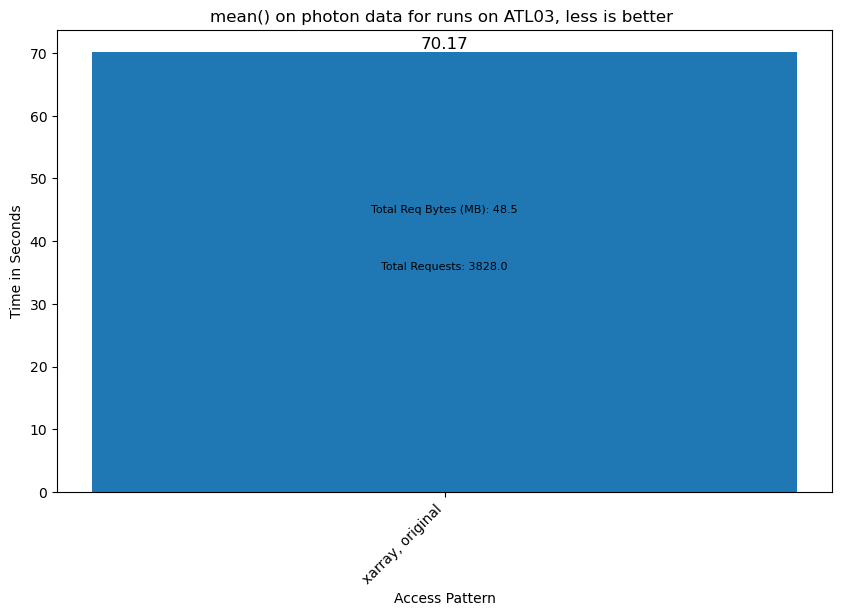

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in df.groupby(['library', 'format']):
    library, format = name
    x = f'{library}, {format}'
    y = group['time'].mean()
    ax.bar(f'{library}, {format}', group['time'].mean(), label=f'{library}, {format}', align='center')
    ax.text(x, y + 0.05, f'{group["time"].mean():.2f}', ha='center', va='bottom', color='black', fontsize=12)
    ax.text(x, y - (y/2), f'Total Requests: {group["total_requests"].mean()}', ha='center', va='bottom', color='black', fontsize=8)
    ax.text(x, y - (y/2.7), f'Total Req Bytes (MB): {round(group["total_requested_bytes"].mean() / (1024*1024) , 2)}', ha='center', va='bottom', color='black', fontsize=8)

# Set labels and title
ax.set_xlabel('Access Pattern')
ax.set_ylabel('Time in Seconds')
ax.set_title(f'mean() on photon data for runs on ATL03, less is better ')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# # Show legend
# ax.legend()

# Show the plot
with plt.xkcd():
    # This figure will be in XKCD-style
    fig1 = plt.figure()